Course: https://course.fast.ai/Lessons/lesson1.html

Define duckduckgo image downloader 

In [1]:
from fastcore.all import *
import time

def search_images(term, max_images=50):
    url = 'https://duckduckgo.com/'
    res = urlread(url,data={'q':term})
    searchObj = re.search(r'vqd=([\d-]+)\&', res)
    requestUrl = url + 'i.js'
    params = dict(l='us-en', o='json', q=term, vqd=searchObj.group(1), f=',,,', p='1', v7exp='a')
    urls,data = set(),{'next':1}
    while len(urls)<max_images and 'next' in data:
        data = urljson(requestUrl,data=params)
        urls.update(L(data['results']).itemgot('image'))
        requestUrl = url + data['next']
        time.sleep(0.2)
    return L(urls)[:max_images]

Download a bird image

In [2]:
urls = search_images('bird photos', max_images=1)
urls[0]

'https://wallpapertag.com/wallpaper/full/8/1/5/710025-lovely-birds-wallpaper-2560x1600-photo.jpg'

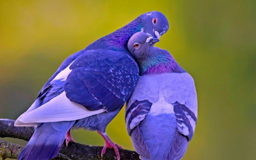

In [3]:
from fastdownload import download_url
download_url(urls[0], 'bird.jpg', show_progress=False)

from fastai.vision.all import *
im = Image.open('bird.jpg')
im.to_thumb(256,256)

Batch download bird and forest images

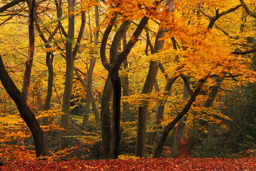

In [4]:
download_url(search_images('forest photos', max_images=1)[0], 'forest.jpg', show_progress=False)
Image.open('forest.jpg').to_thumb(256,256)

In [5]:
searches = 'forest','bird'
path = Path('bird_or_not')

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    resize_images(path/o, max_size=400, dest=path/o)

In [6]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

0

Align images for training

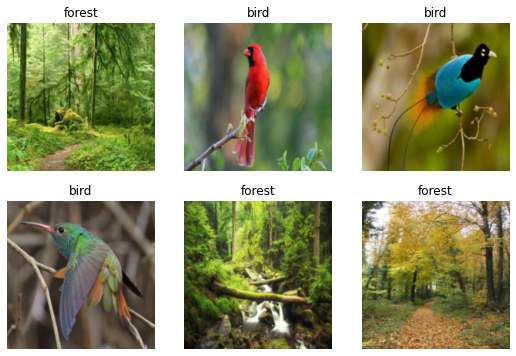

In [7]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path)

dls.show_batch(max_n=6)

Perform training

In [8]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

/home/vscode/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and will be removed in 0.15. Please use keyword parameter(s) instead.
  warnings.warn(
/home/vscode/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,time
0,1.333079,0.614460,0.368421,00:01


epoch,train_loss,valid_loss,error_rate,time
0,0.808977,0.479030,0.263158,00:02
1,0.685158,0.393589,0.210526,00:02
2,0.521199,0.241763,0.157895,00:02


In [9]:
is_bird,_,probs = learn.predict(PILImage.create('bird.jpg'))
print(f"This is a: {is_bird}.")
print(f"Probability it's a bird: {probs[0]:.4f}")

This is a: bird.
Probability it's a bird: 1.0000
